In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import casadi as ca
from pytope import Polytope
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [2]:
def gen_drive_area(vertices):
    Drive_Area = Polytope(vertices*(0.00814636091724916*12))
    Drive_Area_visual = Polytope(vertices)
    A_road = Drive_Area.A
    b_road = Drive_Area.b
    return Drive_Area, Drive_Area_visual, A_road, b_road

# EV 1
road_vertices_1 = np.array([
    [-200, 0],      
    [800, 0],    
    [800, 50],  
    [-200, 50],       
])

Drive_Area_1, Drive_Area_visual_1, A_road_1, b_road_1 = gen_drive_area(road_vertices_1)

# EV 2
road_vertices_2 = np.array([
    [-200, 0],      
    [800, 0],    
    [800, 50],  
    [-200, 50],    
])

Drive_Area_2, Drive_Area_visual_2, A_road_2, b_road_2 = gen_drive_area(road_vertices_2)

In [3]:
image_param = {
  "datasets": {
    "ind": {
      "scale_down_factor": 12,  
      "relevant_areas": { 
        "1": {
          "x_lim": [2000, 11500],  
          "y_lim": [9450, 0]  
        },
        "2": {
          "x_lim": [0, 12500],
          "y_lim": [7400, 0]
        },
        "3": {
          "x_lim": [0, 11500],
          "y_lim": [9365, 0]
        },
        "4": {
          "x_lim": [2700, 15448],
          "y_lim": [9365, 0]
        }
      }
    }
  }
}
location_id = "2"
scale_down_factor = image_param["datasets"]["ind"]["scale_down_factor"]
x_lim_0 = -75
x_lim_1 = 675
y_lim_0 = -15
y_lim_1 = 60
data_id = "08"
recordingMeta_filepath = f"../../data/{data_id}_recordingMeta.csv"
tracks_filepath = f"../../data/{data_id}_tracks.csv"
tracksMeta_filepath = f"../../data/{data_id}_tracksMeta.csv"

tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 18]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
vehicle_data = pd.read_csv(tracksMeta_filepath)
filtered_vehicle_param = vehicle_data[vehicle_data['trackId'] == 18]
sv_width = filtered_vehicle_param["width"]
sv_length = filtered_vehicle_param["length"]
acc_vals= np.vstack((xAcc,yAcc))
recordingMeta = pd.read_csv(recordingMeta_filepath)
orthoPxToMeter = recordingMeta["orthoPxToMeter"].iloc[0]
image_to_real = orthoPxToMeter*scale_down_factor
real_to_image = 1/image_to_real

In [4]:
class polytope_estimation_OR():
    def __init__(self, Param):

        self.SV_Acc = Param["init_acc"]
        self.N = Param["N"] 
        self.T = Param["T"] 
        self.radius = Param["radius"]
        self.num_vertices = Param["num_vertices"]
        self.l_f = Param["l_f"] 
        self.l_r = Param["l_r"] 
        self.l_veh = Param["l_veh"] 
        self.w_veh = Param["w_veh"] 
        self.DEV = Param["DEV"]
        self.Q1 = Param["Q1"]
        self.Q2 = Param["Q2"]
        self.Q3 = Param["Q3"]
        self.Q4 = Param["Q4"]
        self.Q5 = Param["Q5"]
        self.Q6 = Param["Q6"]
        self.Q7 = Param["Q7"]
        self.Q8 = Param["Q8"]
        self.d_min = Param["d_min"]
        self.A_road = Param["A_road"]
        self.b_road = Param["b_road"]
        self.v_low = Param["v_low"]
        self.v_up = Param["v_up"]
        self.acc_low = Param["acc_low"]
        self.acc_up = Param["acc_up"]
        self.delta_low = Param["delta_low"]
        self.delta_up = Param["delta_up"]
        self.RefSpeed = Param["RefSpeed"]
        self.RefPos = Param["RefPos"]
        
        # sv 1
        self.U_SV_Poly1 = self.Generate_Polytope(self.radius,self.num_vertices)
        self.H1 = self.U_SV_Poly1.A
        self.h1 = self.U_SV_Poly1.b 
        self.nv1 = np.size(self.H1, 0)
        self.nu1 = np.size(self.H1, 1)
        for i in range(self.nv1):
            self.H1[i,:] /= self.h1[i]
        self.h1 = np.ones_like(self.h1)
        self.LP1 = self.OR_LP1()
        self.theta_pre1,self.y_pre1,self.rho_pre1 = self.LP1(np.array([[0],[0]]),np.zeros((self.nu1,1)),0.1*np.ones((self.nv1,1)))

        self.MPC = self.MPCFormulation()


    def Return(self,SV_Acc_new, SV_Pos_new, SV_Vel_new, current_x_EV):

        RefSpeed = self.RefSpeed
        RefPos = self.RefPos
        G1, g1, center_list1, Occupancy_SV1 = self.ReachableSet(SV_Acc_new, SV_Pos_new, SV_Vel_new)
        RefXPos = RefPos[0]
        RefYPos = RefPos[1]
        RefPhi  = RefPos[2]
        Trajectory_k, Control_k, J_k, s_k = self.MPC(G1, g1, center_list1, current_x_EV, RefSpeed, RefXPos, RefYPos, RefPhi)
        Trajectory_k = Trajectory_k.full( )
        Control_k = Control_k.full( )

        return Control_k[:, 0], Trajectory_k, J_k.full( ), Occupancy_SV1

    def ReachableSet(self,SV_Acc_new, SV_Pos_new, SV_Vel_new):
        self.U_Hat_Poly1 = self.OR(SV_Acc_new)

        A_SV = np.array([[1, self.T, 0, 0], [0, 1, 0, 0], [0, 0, 1, self.T], [0, 0, 0, 1]])
        B_SV = np.array([[0.5*self.T**2, 0], [self.T, 0], [0, 0.5*self.T**2], [0, self.T]])
        BU = B_SV*self.U_Hat_Poly1
        Reachable_Set1 = list()
        Occupancy_SV1 = list()
        center_list1 = np.zeros((2, self.N))  # Center array for first vehicle
        x_t = np.array([SV_Pos_new[0], SV_Vel_new[0], SV_Pos_new[1], SV_Vel_new[1]])
        Reachable_Set1.append(x_t)
        G1 = np.zeros((4, 2*self.N)) 
        g1 = np.zeros((4, self.N))

        for t in range(1,self.N+1):
            if t == 1:
                reachable_set_t = (A_SV@Reachable_Set1[t - 1] + BU) 
            else:
                try:
                    reachable_set_t = (A_SV*Reachable_Set1[t - 1] + BU) 
                except:
                    reachable_set_t = Reachable_Set1[t - 1] 
            
            vertex = reachable_set_t.V
            vertex_xy = np.delete(vertex, [1, 3], axis = 1)
            
            # Calculate and store center for first vehicle
            center_list1[:, t-1] = np.mean(vertex_xy, axis=0)
            
            occupancy_SV_t = Polytope(vertex_xy) 
            occupancy_SV_t.minimize_V_rep()
            temp_poly = occupancy_SV_t
            G1[:, 2*t-2:2*t] = temp_poly.A
            g1[:, t-1] = temp_poly.b.reshape(4, )

            Occupancy_SV1.append(temp_poly)
            Reachable_Set1.append(reachable_set_t)

        return G1, g1, center_list1, Occupancy_SV1
    
    def MPCFormulation(self):

        d_min = self.d_min          #minimum distance
        N = self.N                  #prediction length
        DEV = self.DEV              #dimension
        T = self.T                  #sampling interval
        Q1 = self.Q1                #weighting matrix steering wheel angle
        Q2 = self.Q2                #weighting matrix longitudinal jerk
        Q3 = self.Q3                #weighting matrix long. velocity error
        Q4 = self.Q4                #weighting matrix long. pos. error
        Q5 = self.Q5                #weighting matrix lat. pos. error
        Q6 = self.Q6                #weighting matrix heading. error
        Q7 = self.Q7                #weighting matrix slack variable
        Q8 = self.Q8
        A_road = self.A_road        #driving area.A
        b_road = self.b_road        #driving area.B
        v_up = self.v_up 
        v_low = self.v_low
        acc_low = self.acc_low 
        acc_up = self.acc_up 
        delta_low = self.delta_low 
        delta_up = self.delta_up

        opti = ca.Opti( )
        X = opti.variable(DEV, N + 1)
        U = opti.variable(2, N)
        delta = U[0, :]
        eta   = U[1, :]
        lam1 = opti.variable(4, N)
        s   = opti.variable(N, 1)

        G1 = opti.parameter(4, 2*N)
        g1 = opti.parameter(4, N)
        center_list1 = opti.parameter(2, N)
        Initial = opti.parameter(DEV, 1)
        v_ref = opti.parameter( )
        x_ref = opti.parameter( )
        y_ref = opti.parameter( )
        phi_ref = opti.parameter( )

        opti.subject_to(X[:, 0] == Initial)
        for k in range(N):
            k1 = self.vehicle_model(X[:, k], delta[k], eta[k])
            k2 = self.vehicle_model(X[:, k] + T/2*k1, delta[k], eta[k])
            k3 = self.vehicle_model(X[:, k] + T/2*k2, delta[k], eta[k])
            k4 = self.vehicle_model(X[:, k] + T*k3, delta[k], eta[k])
            x_next = X[:, k] + T/6 * (k1 + 2*k2 + 2*k3 + k4)
            opti.subject_to(X[:, k + 1] == x_next) 
        x = X[0, 1::]
        y = X[1, 1::]
        phi = X[2, 1::]
        v = X[3, 1::]
        a = X[4, 1::]
        phi_error = phi[-1] - phi_ref
        v_error = v[-1] - v_ref # longitudinal speed error
        x_error = x[-1] - x_ref # longitudinal position error
        y_error = y[-1] - y_ref # lateral position error
        J = 0
        

        for k in range(N):
            p_point = X[0:2, k + 1]
            
            G_point1 = G1[:, 2*k:2*k + 2]
            g_point1 = g1[:, k]
            temp1 = G_point1.T@lam1[:, k]
            scale_factor = 1.0
            opti.subject_to((G_point1@ca.reshape(p_point,2,1) - g_point1).T@lam1[:, k] >= scale_factor*d_min - s[k])
            opti.subject_to(temp1[0]**2 + temp1[1]**2 == 1)
            opti.subject_to(0 <= lam1[:, k])
            opti.subject_to(A_road@ca.reshape(p_point,2,1) <= b_road)
        opti.subject_to(0 <= s)
        # opti.subject_to(opti.bounded(0, s, d_min))
        opti.subject_to(opti.bounded(v_low, v, v_up))
        opti.subject_to(opti.bounded(acc_low, a, acc_up))
        opti.subject_to(opti.bounded(delta_low, delta, delta_up))
        
        J += delta@Q1@delta.T + eta@Q2@eta.T + Q3*v_error@v_error.T + Q4*x_error@x_error.T + Q5*y_error@y_error.T + Q6*phi_error@phi_error.T + Q7*(s.T@s)
        opti.minimize(J)
        
        opts = {"ipopt.print_level": 0, "print_time": False} #"ipopt.linear_solver": "ma57",
        opti.solver('ipopt', opts)

        return opti.to_function('g', [G1, g1, center_list1, Initial, v_ref, x_ref, y_ref, phi_ref], [X, U, J, s])
    
    def vehicle_model(self, w, delta, eta):
        l_f = self.l_f
        l_r = self.l_r
        
        beta = np.arctan(l_r/(l_f + l_r)*np.tan(delta))
        x_dot   = w[3]*np.cos(w[2] + beta) 
        y_dot   = w[3]*np.sin(w[2] + beta)
        phi_dot = w[3]/(l_r)*np.sin(beta)
        v_dot = w[4]
        a_dot = eta
        
        return ca.vertcat(x_dot, y_dot, phi_dot, v_dot, a_dot)
    

    def Generate_Polytope(self, radius, num_vertices):

        if num_vertices != 4:
            angles = np.linspace(0, 2 * np.pi, num_vertices, endpoint=False)
            x_coords = radius * np.cos(angles)
            y_coords = radius * np.sin(angles)

            vertices = np.column_stack((x_coords, y_coords))
            U_SV_Poly = Polytope(vertices)

            return U_SV_Poly
        else:
            low_bound_control  = (-radius, -radius)
            up_bound_control   = (radius,   radius)
            U_SV_Poly = Polytope(lb = low_bound_control, ub = up_bound_control)
            return U_SV_Poly  

    def OR_LP1(self):

        H = self.H1
        nv = self.nv1
        nu = self.nu1

        opti = ca.Opti()

        rho = opti.variable()
        theta = opti.variable(nv,1)
        y = opti.variable(nu,1)

        samples = opti.parameter(nu, 1)
        y_pre = opti.parameter(nu,1)
        theta_pre = opti.parameter(nv,1)

        opti.minimize(rho + np.ones((1, nv))@theta)

        opti.subject_to(H @ samples-H @ y <= theta)
        opti.subject_to(H @ y_pre + theta_pre <= H @ y + theta)
        opti.subject_to(H @ y <= (1 - rho)@np.ones((nv,1)))
        opti.subject_to(opti.bounded(0, theta, 1))
        opti.subject_to(opti.bounded(0, rho, 1))
        opti.subject_to(theta <= rho@np.ones((nv,1)))

        opts = {"ipopt.print_level": 0, "print_time": False}
        opti.solver('ipopt', opts)

        return opti.to_function('f', [samples, y_pre, theta_pre], [theta, y, rho])    
    
    def OR(self,SV_Acc_new):
        self.theta_pre1,self.y_pre1,self.rho_pre1 = self.LP1(SV_Acc_new,self.y_pre1,self.theta_pre1)
        U_Hat_Poly1 = Polytope(self.H1, self.theta_pre1)+self.y_pre1

        return U_Hat_Poly1

    def Plot_Polytope(self):

        plt.figure()
        self.U_SV_Poly.plot(color = 'b', alpha = 0.3)
        self.U_Hat_Poly.plot(color = 'r', alpha = 0.3)

        plt.scatter(self.SV_Acc[0,:],self.SV_Acc[1,:],marker='x',color = 'black')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Polytope Visualization")
        plt.xlabel("Long Acc")
        plt.ylabel("Lat Acc")
        plt.grid(True)
        plt.show()

In [5]:
N = 10
T = 0.24

In [6]:
Param_1 = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": N, # Reachability Prediction Length
    "T": T, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.2, # length of vehicle
    "w_veh": 1.5, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 5, # heading. error
    "Q7": 300,
    "Q8": 50,
    "d_min": 6,
    "A_road": A_road_1,
    "b_road": b_road_1,
    "v_low": -1,
    "v_up": 2.5,
    "acc_low": -2,
    "acc_up": 3,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RefPos": [580*image_to_real,20*image_to_real,0]
}
x_EV_1_initial = np.array([20*image_to_real, 20*image_to_real, 0, 0, 0])

In [7]:
Param_2 = {
    "init_acc": acc_vals[:,0].reshape(2,1),
    "N": N, # Reachability Prediction Length
    "T": T, # Sampling Interval
    "radius": 8,
    "num_vertices": 4,
    "l_f": 1.5, # Distance from CoG to Front Axle
    "l_r": 1.5, # Distance from CoG to Rear Axle
    "l_veh": 4.2, # length of vehicle
    "w_veh": 1.5, # width of vehicle
    "DEV": 5,
    "Q1": 1, # steering wheel angle
    "Q2": 1, # longitudinal jerk
    "Q3": 1, # long. velocity error
    "Q4": 10, # long. pos. error
    "Q5": 10, # lat. pos. error
    "Q6": 5, # heading. error
    "Q7": 300,
    "Q8": 50,
    "d_min": 6,
    "A_road": A_road_2,
    "b_road": b_road_2,
    "v_low": -1,
    "v_up": 3,
    "acc_low": -2,
    "acc_up": 2.5,
    "delta_low": -0.8,
    "delta_up": 0.8,
    "RefSpeed": 0,
    "RefPos": [20*image_to_real,20*image_to_real,-np.pi]
}
x_EV_2_initial = np.array([580*image_to_real, 20*image_to_real, -np.pi, 0, 0])

In [8]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

x_EV_2_initial = generate_random_initial_state(
    x_range=(580*image_to_real, 620*image_to_real),      # Starting further back
    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
    phi_range=(-np.pi, -np.pi+0.1), # Roughly pointing left
    v_range=(-0.5, 1),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

# For EV (Ego Vehicle) 
x_EV_1_initial = generate_random_initial_state(
    x_range=(-20*image_to_real, 20*image_to_real),      # Starting in middle
    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
    phi_range=(0,0.1),  # Roughly pointing right
    v_range=(-0.5, 1),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

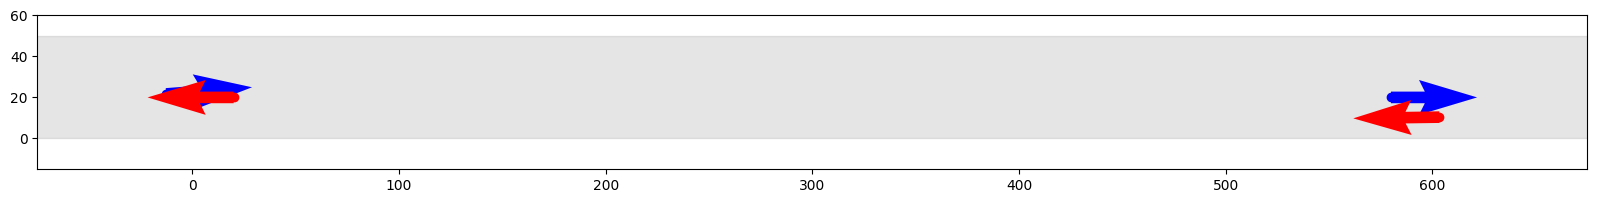

In [9]:
fig, ax = plt.subplots(figsize=(20,2))
arrow_length = 5
Drive_Area_visual_2.plot(color = 'grey', alpha = 0.2)
# EV1
plt.scatter(x_EV_1_initial[0]*real_to_image,x_EV_1_initial[1]*real_to_image,color='blue')
plt.quiver(x_EV_1_initial[0]*real_to_image,
           x_EV_1_initial[1]*real_to_image,
           arrow_length*np.cos(x_EV_1_initial[2]),
           arrow_length*np.sin(x_EV_1_initial[2]),
           color='blue')
plt.scatter(Param_1["RefPos"][0]*real_to_image,Param_1["RefPos"][1]*real_to_image,color='blue')
plt.quiver(Param_1["RefPos"][0]*real_to_image,
           Param_1["RefPos"][1]*real_to_image,
           arrow_length*np.cos(Param_1["RefPos"][2]),
           arrow_length*np.sin(Param_1["RefPos"][2]),
           color='blue')
# EV2
plt.scatter(x_EV_2_initial[0]*real_to_image,x_EV_2_initial[1]*real_to_image,color='r')
plt.quiver(x_EV_2_initial[0]*real_to_image,
           x_EV_2_initial[1]*real_to_image,
           arrow_length*np.cos(x_EV_2_initial[2]),
           arrow_length*np.sin(x_EV_2_initial[2]),
           color='r')
plt.scatter(Param_2["RefPos"][0]*real_to_image,Param_2["RefPos"][1]*real_to_image,color='r')
plt.quiver(Param_2["RefPos"][0]*real_to_image,
           Param_2["RefPos"][1]*real_to_image,
           arrow_length*np.cos(Param_2["RefPos"][2]),
           arrow_length*np.sin(Param_2["RefPos"][2]),
           color='r')
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([y_lim_0,y_lim_1])
plt.show()

In [10]:
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

x_EV_2_initial = generate_random_initial_state(
    x_range=(580*image_to_real, 620*image_to_real),      # Starting further back
    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
    phi_range=(-np.pi, -np.pi+0.1), # Roughly pointing left
    v_range=(-0.5, 1),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)

# For EV (Ego Vehicle) 
x_EV_1_initial = generate_random_initial_state(
    x_range=(-20*image_to_real, 20*image_to_real),      # Starting in middle
    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
    phi_range=(0,0.1),  # Roughly pointing right
    v_range=(-0.5, 1),    # Around 1 m/s
    a_range=(-0.1, 0.1)    # Small initial acceleration
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



Step 69: 100%|██████████| 70/70 [00:18<00:00,  3.86it/s]


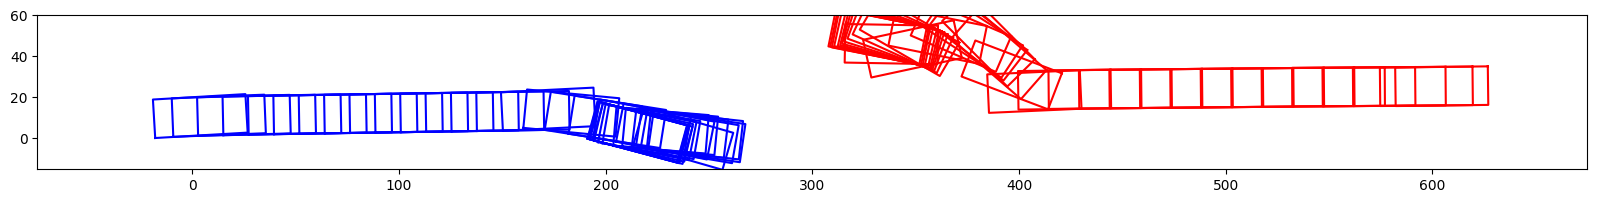

In [11]:
#test mpc
N_Sam = 70
test_polytope_1 = polytope_estimation_OR(Param_1)
State_EV_1_R     = np.zeros((5, N_Sam+1))
State_EV_1_R[:, 0] = x_EV_1_initial
X_EV_1_Planning_R = list( )
X_EV_1_Planning_R.append(x_EV_1_initial[0:2].reshape(2,1))

test_polytope_2 = polytope_estimation_OR(Param_2)
State_EV_2_R     = np.zeros((5, N_Sam+1))
State_EV_2_R[:, 0] = x_EV_2_initial 
X_EV_2_Planning_R = list( )
X_EV_2_Planning_R.append(x_EV_2_initial[0:2].reshape(2,1))

fig, ax = plt.subplots(figsize=(20,2))

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2
i = 0

def reach_destination(x_EV_initial,x_ref):
    if abs(x_EV_initial[0] - x_ref[0]) <= 1 and abs(x_EV_initial[1] - x_ref[1]) <= 1:
        return False
    else:
        return True

pbar = tqdm(range(N_Sam))
for i in pbar:
    pbar.set_description(f"Step {i}")
    EV_1_phi = State_EV_1_R[2, i]
    EV_1_acc = np.array([State_EV_1_R[4, i]*np.cos(EV_1_phi),State_EV_1_R[4, i]*np.sin(EV_1_phi)])
    EV_1_pos = np.array([State_EV_1_R[0, i],State_EV_1_R[1, i]])
    EV_1_vel = np.array([State_EV_1_R[3, i]*np.cos(EV_1_phi),State_EV_1_R[3, i]*np.sin(EV_1_phi)])
    EV_2_phi = State_EV_2_R[2, i]
    EV_2_acc = np.array([State_EV_2_R[4, i]*np.cos(EV_2_phi),State_EV_2_R[4, i]*np.sin(EV_2_phi)])
    EV_2_pos = np.array([State_EV_2_R[0, i],State_EV_2_R[1, i]])
    EV_2_vel = np.array([State_EV_2_R[3, i]*np.cos(EV_2_phi),State_EV_2_R[3, i]*np.sin(EV_2_phi)])


    #   U_R: input, trajectory_planning_k: predicted EV, J_R:cost, Occupancy_SV_aug_R:Occupancy
    U_R_1, trajectory_planning_k_1, J_R_1, Occupancy_SV_aug_R1_1 = test_polytope_1.Return(EV_2_acc, EV_2_pos, EV_2_vel, State_EV_1_R[:, i])
    U_R_2, trajectory_planning_k_2, J_R_2, Occupancy_SV_aug_R1_2 = test_polytope_2.Return(EV_1_acc, EV_1_pos, EV_1_vel, State_EV_2_R[:, i])

    X_EV_1_Planning_R.append(trajectory_planning_k_1[0:2,1].reshape(2,1))
    State_EV_1_R[:, i + 1] = trajectory_planning_k_1[:, 1]
    X_EV_2_Planning_R.append(trajectory_planning_k_2[0:2,1].reshape(2,1))
    State_EV_2_R[:, i + 1] = trajectory_planning_k_2[:, 1]
    
    if i % 2 == 0:
        corners_ev = np.array([
            [-half_length_sv, -half_width_sv],
            [half_length_sv, -half_width_sv],
            [half_length_sv, half_width_sv],
            [-half_length_sv, half_width_sv]
        ])

        rad_yaw_ev_1 = trajectory_planning_k_1[2,1]
        rotation_matrix_ev_1 = np.array([
                [np.cos(rad_yaw_ev_1), -np.sin(rad_yaw_ev_1)],
                [np.sin(rad_yaw_ev_1),  np.cos(rad_yaw_ev_1)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev_1.T
        rotated_corners_ev[:, 0] += State_EV_1_R[0, i+1]*real_to_image
        rotated_corners_ev[:, 1] += State_EV_1_R[1, i+1]*real_to_image
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'b-')

        rad_yaw_ev_2 = trajectory_planning_k_2[2,1]
        rotation_matrix_ev_2 = np.array([
                [np.cos(rad_yaw_ev_2), -np.sin(rad_yaw_ev_2)],
                [np.sin(rad_yaw_ev_2),  np.cos(rad_yaw_ev_2)]
            ])
        rotated_corners_ev = corners_ev.reshape(4,2) @ rotation_matrix_ev_2.T
        rotated_corners_ev[:, 0] += State_EV_2_R[0, i+1]*real_to_image
        rotated_corners_ev[:, 1] += State_EV_2_R[1, i+1]*real_to_image
        rotated_corners_ev = np.vstack([rotated_corners_ev, rotated_corners_ev[0]])
        plt.plot(rotated_corners_ev[:, 0], rotated_corners_ev[:, 1], 'r-')

        # for j in range(10):
        #     occupancy = Polytope(Occupancy_SV_aug_R1_1[j].A, Occupancy_SV_aug_R1_1[j].b*real_to_image)
        #     occupancy.plot(color = 'g', alpha = 0.1)
        #     occupancy = Polytope(Occupancy_SV_aug_R1_2[j].A, Occupancy_SV_aug_R1_2[j].b*real_to_image)
        #     occupancy.plot(color = 'b', alpha = 0.1)


# plt.plot(State_EV_1_R[0]*real_to_image, State_EV_1_R[1]*real_to_image)
# plt.plot(State_EV_2_R[0]*real_to_image, State_EV_2_R[1]*real_to_image)
ax.set_xlim([x_lim_0,x_lim_1])
ax.set_ylim([y_lim_0,y_lim_1])
plt.show()

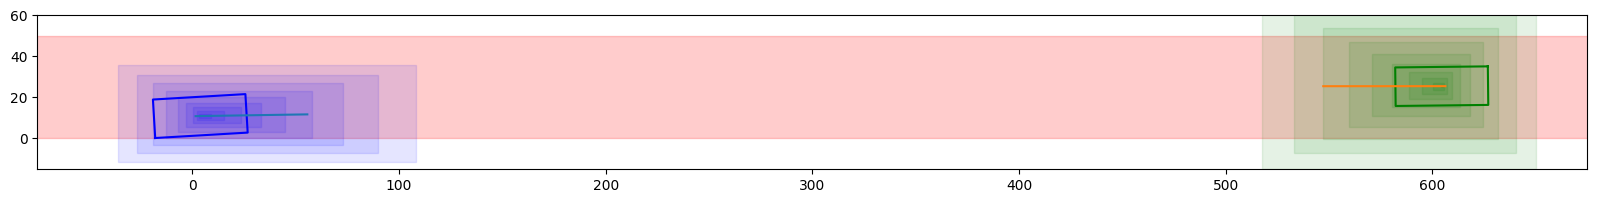

In [12]:
#test mpc
N_Sam = 120
test_polytope_1 = polytope_estimation_OR(Param_1)
State_EV_1_R     = np.zeros((5, N_Sam+1))
State_EV_1_R[:, 0] = x_EV_1_initial
X_EV_1_Planning_R = list()
X_EV_1_Planning_R.append(x_EV_1_initial[0:2].reshape(2,1))

test_polytope_2 = polytope_estimation_OR(Param_2)
State_EV_2_R     = np.zeros((5, N_Sam+1))
State_EV_2_R[:, 0] = x_EV_2_initial
X_EV_2_Planning_R = list()
X_EV_2_Planning_R.append(x_EV_2_initial[0:2].reshape(2,1))

fig, ax = plt.subplots(figsize=(20,2))

half_width_sv = real_to_image*sv_width / 2
half_length_sv = real_to_image*sv_length / 2

def draw_vehicle(ax, corners, rotation_matrix, position, color):
    rotated_corners = corners.reshape(4,2) @ rotation_matrix.T
    rotated_corners[:, 0] += position[0]
    rotated_corners[:, 1] += position[1]
    rotated_corners = np.vstack([rotated_corners, rotated_corners[0]]) 
    ax.plot(rotated_corners[:, 0], rotated_corners[:, 1], color)

corners_ev = np.array([
    [-half_length_sv, -half_width_sv],
    [half_length_sv, -half_width_sv],
    [half_length_sv, half_width_sv],
    [-half_length_sv, half_width_sv]
])

def update(frame):
    ax.clear()
    ax.set_xlim([x_lim_0, x_lim_1])
    ax.set_ylim([y_lim_0, y_lim_1])
    Drive_Area_visual_2.plot(color = 'r', alpha = 0.2)
    
    # Calculate states and controls for EV1
    EV_1_phi = State_EV_1_R[2, frame]
    EV_1_acc = np.array([State_EV_1_R[4, frame]*np.cos(EV_1_phi),State_EV_1_R[4, frame]*np.sin(EV_1_phi)])
    EV_1_pos = np.array([State_EV_1_R[0, frame],State_EV_1_R[1, frame]])
    EV_1_vel = np.array([State_EV_1_R[3, frame]*np.cos(EV_1_phi),State_EV_1_R[3, frame]*np.sin(EV_1_phi)])
    
    # Calculate states and controls for EV2
    EV_2_phi = State_EV_2_R[2, frame]
    EV_2_acc = np.array([State_EV_2_R[4, frame]*np.cos(EV_2_phi),State_EV_2_R[4, frame]*np.sin(EV_2_phi)])
    EV_2_pos = np.array([State_EV_2_R[0, frame],State_EV_2_R[1, frame]])
    EV_2_vel = np.array([State_EV_2_R[3, frame]*np.cos(EV_2_phi),State_EV_2_R[3, frame]*np.sin(EV_2_phi)])

    # Get trajectory planning for each EV
    U_R_1, trajectory_planning_k_1, J_R_1, Occupancy_SV_aug_R1_1 = test_polytope_1.Return(
        EV_2_acc, 
        EV_2_pos, 
        EV_2_vel, 
        State_EV_1_R[:, frame])

    U_R_2, trajectory_planning_k_2, J_R_2, Occupancy_SV_aug_R1_2 = test_polytope_2.Return(
        EV_1_acc, 
        EV_1_pos, 
        EV_1_vel, 
        State_EV_2_R[:, frame])
    # Update states and planning
    X_EV_1_Planning_R.append(trajectory_planning_k_1[0:2,1].reshape(2,1))
    State_EV_1_R[:, frame + 1] = trajectory_planning_k_1[:, 1]
    X_EV_2_Planning_R.append(trajectory_planning_k_2[0:2,1].reshape(2,1))
    State_EV_2_R[:, frame + 1] = trajectory_planning_k_2[:, 1]

    # Draw vehicles
    # EV1
    rad_yaw_ev_1 = trajectory_planning_k_1[2,1]
    rotation_matrix_ev_1 = np.array([
        [np.cos(rad_yaw_ev_1), -np.sin(rad_yaw_ev_1)],
        [np.sin(rad_yaw_ev_1), np.cos(rad_yaw_ev_1)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev_1, 
                [State_EV_1_R[0, frame+1]*real_to_image, State_EV_1_R[1, frame+1]*real_to_image], 'b-')

    # EV2
    rad_yaw_ev_2 = trajectory_planning_k_2[2,1]
    rotation_matrix_ev_2 = np.array([
        [np.cos(rad_yaw_ev_2), -np.sin(rad_yaw_ev_2)],
        [np.sin(rad_yaw_ev_2), np.cos(rad_yaw_ev_2)]
    ])
    draw_vehicle(ax, corners_ev, rotation_matrix_ev_2, 
                [State_EV_2_R[0, frame+1]*real_to_image, State_EV_2_R[1, frame+1]*real_to_image], 'g-')

    # Plot trajectories
    ax.plot(trajectory_planning_k_1[0]*real_to_image, trajectory_planning_k_1[1]*real_to_image)
    ax.plot(trajectory_planning_k_2[0]*real_to_image, trajectory_planning_k_2[1]*real_to_image)

    for i in range(Param_1["N"]):
        occupancy = Polytope(Occupancy_SV_aug_R1_1[i].A, Occupancy_SV_aug_R1_1[i].b*real_to_image)
        occupancy.plot(color = 'g', alpha = 0.1)
        occupancy = Polytope(Occupancy_SV_aug_R1_2[i].A, Occupancy_SV_aug_R1_2[i].b*real_to_image)
        occupancy.plot(color = 'b', alpha = 0.1)

frame_length = N_Sam
ani = FuncAnimation(fig, update, frames=range(0, frame_length), interval=100, repeat=False)
#plt.show()
ani.save("../../videos/deadlock/deadlock_simulation.mp4", writer='ffmpeg', fps=15)

In [13]:
from IPython.display import Video

# Specify the full file path
video_path = "../../videos/deadlock/deadlock_simulation.mp4"

# Display the video
Video(video_path, embed=True)

In [132]:
a

NameError: name 'a' is not defined

In [ ]:
simulation_time = 150
def generate_random_initial_state(x_range, y_range, phi_range, v_range, a_range):
    """Generate random initial state within specified ranges
    
    Args:
        x_range (tuple): (min, max) range for x position
        y_range (tuple): (min, max) range for y position 
        phi_range (tuple): (min, max) range for heading angle
        v_range (tuple): (min, max) range for velocity
        a_range (tuple): (min, max) range for acceleration
        
    Returns:
        np.array: Random initial state [x, y, phi, v, a]
    """
    return np.array([
        np.random.uniform(*x_range),    # x position
        np.random.uniform(*y_range),    # y position
        np.random.uniform(*phi_range),  # heading angle
        np.random.uniform(*v_range),    # velocity
        np.random.uniform(*a_range)     # acceleration
    ])

def run_monte_carlo_simulation(num_trials, Param_SV, Param_EV):
    # Store results for each trial
    results = {
        'success_count': 0,  # Count of successful arrivals
        'min_distances': [],
        'completion_times': [],
        'trajectories_SV': [],
        'trajectories_EV': [],
        'failed_trials': 0  # Add counter for failed trials
    }
    
    # Add progress bar
    pbar = tqdm(range(num_trials), desc='Running Monte Carlo Trials')
    
    for trial in pbar:
        max_retries = 5  # Maximum number of retry attempts
        retry_count = 0
        success = False
        
        while retry_count < max_retries and not success:
            try:
                # Randomize initial conditions
                # For SV (Subject Vehicle)
                SV_initial = generate_random_initial_state(
                    x_range=(580*image_to_real, 620*image_to_real),      # Starting further back
                    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
                    phi_range=(3.0, 3.28), # Roughly pointing left
                    v_range=(-0.5, 1),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # For EV (Ego Vehicle) 
                EV_initial = generate_random_initial_state(
                    x_range=(-20*image_to_real, 20*image_to_real),      # Starting in middle
                    y_range=(10*image_to_real, 30*image_to_real),        # Within road bounds
                    phi_range=(0.05,0.2),  # Roughly pointing right
                    v_range=(-0.5, 1),    # Around 1 m/s
                    a_range=(-0.1, 0.1)    # Small initial acceleration
                )

                # Run single simulation
                trial_results = run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV)
                
                # Store results
                results['min_distances'].append(trial_results['min_distance'])
                results['completion_times'].append(trial_results['completion_time'])
                results['trajectories_SV'].append(trial_results['trajectory_SV'])
                results['trajectories_EV'].append(trial_results['trajectory_EV'])
                
                if trial_results['success']:
                    results['success_count'] += 1
                
                success = True  # Mark as successful to exit retry loop
                
            except Exception as e:
                retry_count += 1
                if retry_count < max_retries:
                    print(f"\nTrial {trial} failed (attempt {retry_count}/{max_retries}). Error: {str(e)}")
                    print("Retrying with new random initial conditions...")
                else:
                    print(f"\nTrial {trial} failed after {max_retries} attempts. Moving to next trial.")
                    results['failed_trials'] += 1
        
        # Update progress bar with success rate and failure count
        pbar.set_postfix({
            'Success Rate': f"{(results['success_count']/(trial+1))*100:.1f}%",
            'Failed Trials': results['failed_trials']
        })
            
    return results

def run_single_simulation(SV_initial, EV_initial, Param_SV, Param_EV):
    """Run a single simulation with given initial conditions"""
    SV = polytope_estimation_OR(Param_SV)
    State_SV_R = np.zeros((5, simulation_time+1))
    State_SV_R[:, 0] = SV_initial
    
    EV = polytope_estimation_OR(Param_EV)
    State_EV_R = np.zeros((5, simulation_time+1))
    State_EV_R[:, 0] = EV_initial
    
    min_distance = float('inf')
    success = False
    completion_time = simulation_time
    
    # Define goal positions and tolerance
    goal_SV = Param_SV["RefPos"]
    goal_EV = Param_EV["RefPos"]
    position_tolerance = 5.0  # meters
    velocity_tolerance = 0.5  # m/s
    heading_tolerance = 0.1   # radians
    
    for i in range(simulation_time):
        SV_phi = State_SV_R[2, i]
        SV_acc = np.array([State_SV_R[4, i]*np.cos(SV_phi), State_SV_R[4, i]*np.sin(SV_phi)])
        SV_pos = np.array([State_SV_R[0, i], State_SV_R[1, i]])
        SV_vel = np.array([State_SV_R[3, i]*np.cos(SV_phi), State_SV_R[3, i]*np.sin(SV_phi)])
        
        EV_phi = State_EV_R[2, i]
        EV_acc = np.array([State_EV_R[4, i]*np.cos(EV_phi), State_EV_R[4, i]*np.sin(EV_phi)])
        EV_pos = np.array([State_EV_R[0, i], State_EV_R[1, i]])
        EV_vel = np.array([State_EV_R[3, i]*np.cos(EV_phi), State_EV_R[3, i]*np.sin(EV_phi)])
        
        # Calculate distance between vehicles
        distance = np.linalg.norm(EV_pos - SV_pos)
        min_distance = min(min_distance, distance)
        
        # Check if both vehicles have reached their goals
        SV_at_goal = (np.linalg.norm(SV_pos - goal_SV[0:2]) < position_tolerance)
        #print("SV_goal:", np.linalg.norm(SV_pos - goal_SV[0:2]) - position_tolerance)
        EV_at_goal = (np.linalg.norm(EV_pos - goal_EV[0:2]) < position_tolerance)
        #print("EV_goal:", np.linalg.norm(EV_pos - goal_EV[0:2]) - position_tolerance)
        
        if SV_at_goal and EV_at_goal:
            success = True
            completion_time = i
            break
            
        # Update states
        U_R_SV, trajectory_planning_k_SV, _, _ = SV.Return(
            EV_acc.reshape(2,1), EV_pos.reshape(2,1), EV_vel.reshape(2,1), State_SV_R[:, i]
        )
        U_R_EV, trajectory_planning_k_EV, _, _ = EV.Return(
            SV_acc.reshape(2,1), SV_pos.reshape(2,1), SV_vel.reshape(2,1), State_EV_R[:, i]
        )
        
        State_SV_R[:, i + 1] = trajectory_planning_k_SV[:, 1]
        State_EV_R[:, i + 1] = trajectory_planning_k_EV[:, 1]
    
    return {
        'success': success,
        'min_distance': min_distance,
        'completion_time': completion_time,
        'trajectory_SV': State_SV_R,
        'trajectory_EV': State_EV_R
    }

def analyze_monte_carlo_results(results, num_trials):
    """Analyze and visualize Monte Carlo simulation results"""
    # Calculate statistics
    success_rate = results['success_count'] / num_trials * 100
    avg_min_distance = np.mean(results['min_distances'])
    std_min_distance = np.std(results['min_distances'])
    avg_completion_time = np.mean([t for t in results['completion_times'] if t < simulation_time])
    
    # Plot histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(results['min_distances'], bins=30)
    ax1.set_title('Minimum Distances')
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Number of Trials')
    
    completion_times = [t for t in results['completion_times'] if t < simulation_time]
    if completion_times:
        ax2.hist(completion_times, bins=30)
        ax2.set_title('Completion Times')
        ax2.set_xlabel('Time steps')
        ax2.set_ylabel('Number of Trials')
    else:
        ax2.text(0.5, 0.5, 'No successful completions', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Monte Carlo Simulation Results ({num_trials} trials):")
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Minimum Distance: {avg_min_distance:.2f} m")
    print(f"Std Dev of Minimum Distance: {std_min_distance:.2f} m")
    if completion_times:
        print(f"Average Completion Time (successful trials): {avg_completion_time:.2f} steps")
    else:
        print("No successful completions")

Running Monte Carlo Trials: 100%|██████████| 100/100 [1:24:31<00:00, 50.72s/it, Success Rate=6.0%, Failed Trials=0]  


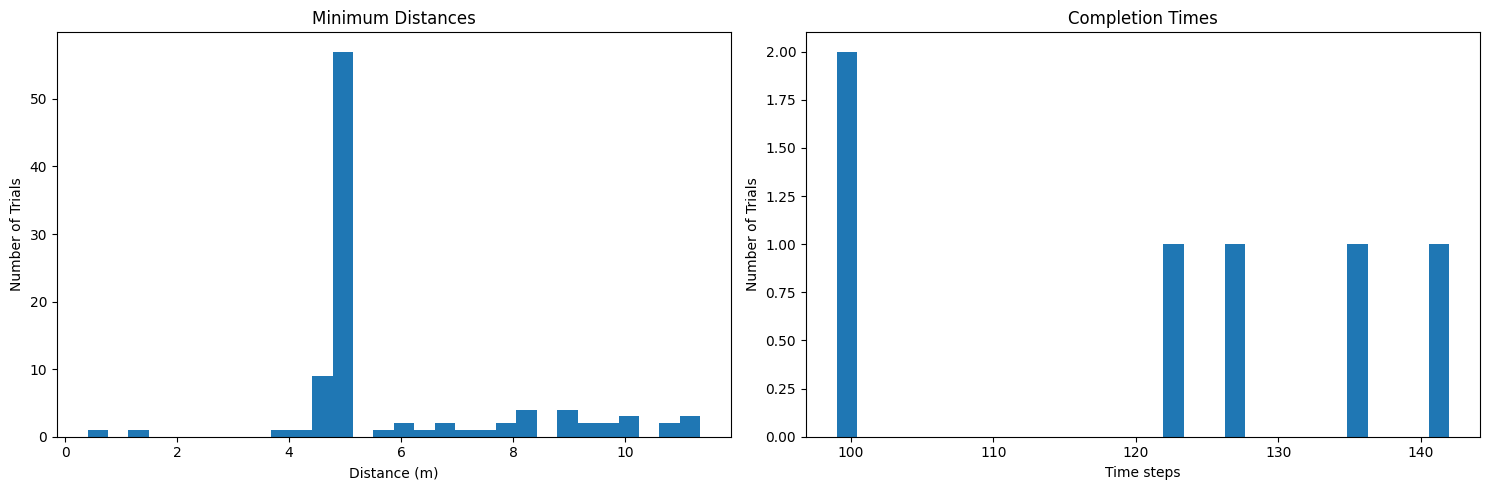

Monte Carlo Simulation Results (100 trials):
Success Rate: 6.00%
Average Minimum Distance: 5.91 m
Std Dev of Minimum Distance: 2.09 m
Average Completion Time (successful trials): 120.83 steps


In [50]:
# Run Monte Carlo analysis with 100 trials
trails = 100
analyze_monte_carlo_results(run_monte_carlo_simulation(trails,Param_2, Param_1),trails)